# Youden J index 

/share/home2/kamtams/jintel/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Processing LOS A, Departure 895, Iteration 1


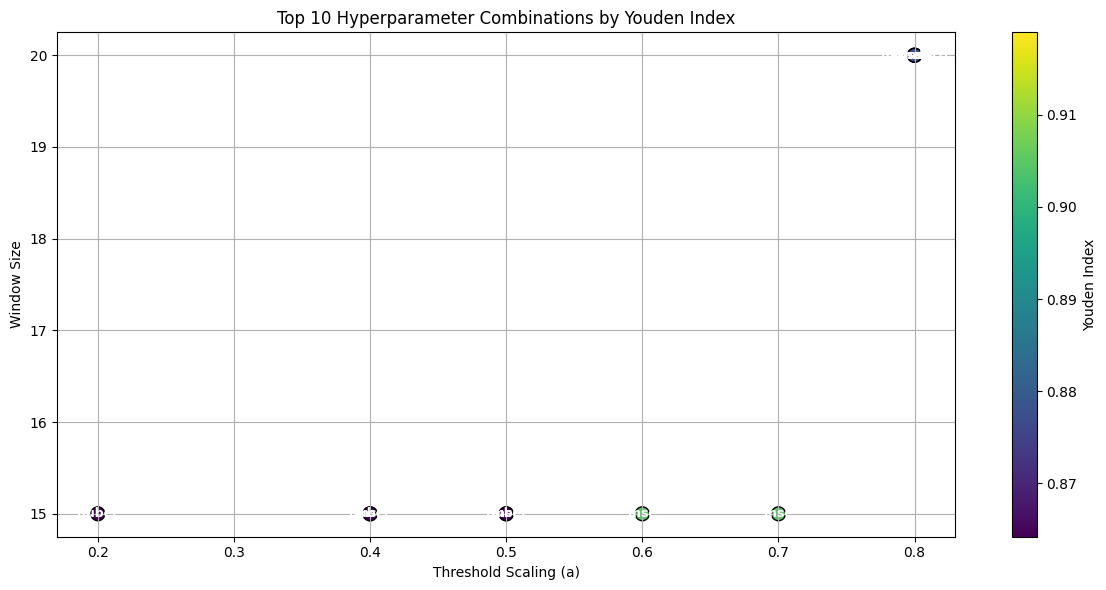

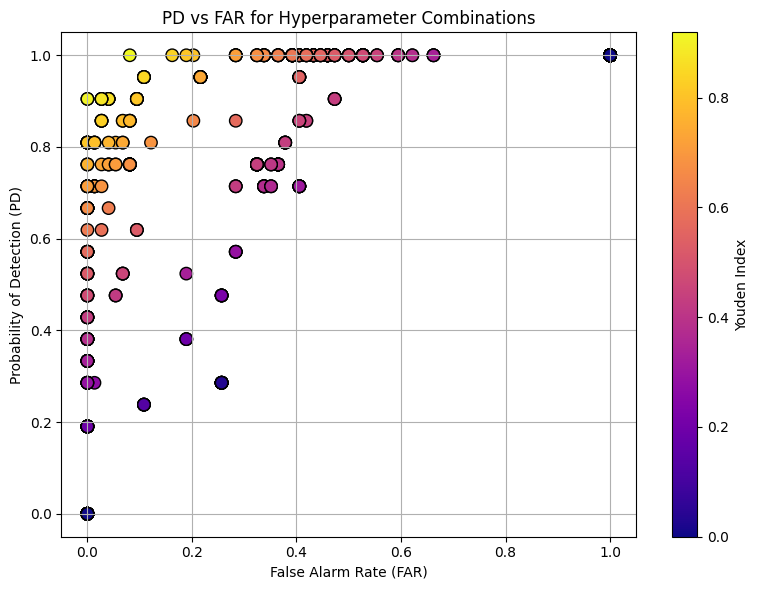


Top 10 global parameter combinations (across all sequences):
       a  window_size  loss_func        PD       FAR  Youden_index
493  0.4           15        mse  1.000000  0.081081      0.918919
553  0.7           15        mse  0.904762  0.000000      0.904762
533  0.6           15        mse  0.904762  0.000000      0.904762
575  0.8           20  hausdorff  0.904762  0.027027      0.877735
579  0.8           20       rmse  0.904762  0.027027      0.877735
513  0.5           15        mse  0.904762  0.027027      0.877735
577  0.8           20        mae  0.904762  0.027027      0.877735
451  0.2           15      huber  0.904762  0.040541      0.864221
491  0.4           15      huber  0.904762  0.040541      0.864221
511  0.5           15      huber  0.904762  0.040541      0.864221


In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, 
                                     GRU, Bidirectional, Dense, 
                                     Reshape, Dropout, Attention, 
                                     Concatenate, LayerNormalization)
from tensorflow.keras import backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Plotting functions ---
def plot_optimization_results(agg_results, top_n=10):
    top = agg_results.sort_values(by='Youden_index', ascending=False).head(top_n)
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(top['a'], top['window_size'],
                          c=top['Youden_index'], cmap='viridis', s=100, edgecolor='k')
    plt.colorbar(scatter, label='Youden Index')
    for i, row in top.iterrows():
        plt.text(row['a'], row['window_size'], row['loss_func'], fontsize=9,
                 ha='center', va='center', color='white', weight='bold')
    plt.title(f'Top {top_n} Hyperparameter Combinations by Youden Index')
    plt.xlabel('Threshold Scaling (a)')
    plt.ylabel('Window Size')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pd_vs_far(agg_results):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(agg_results['FAR'], agg_results['PD'],
                          c=agg_results['Youden_index'], cmap='plasma', s=80, edgecolor='k')
    plt.colorbar(scatter, label='Youden Index')
    plt.title('PD vs FAR for Hyperparameter Combinations')
    plt.xlabel('False Alarm Rate (FAR)')
    plt.ylabel('Probability of Detection (PD)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Model definition ---
def build_prediction_model(input_shape, output_steps, n_features):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    x = GRU(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(output_steps * n_features)(x)
    outputs = Reshape((output_steps, n_features))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.00093286), loss='mse', metrics=['mae', f1])
    return model

def load_trained_model(input_shape, output_steps, n_features):
    model = build_prediction_model(input_shape, output_steps, n_features)
    model.load_weights("gru70_epoch_100.weights.h5")  # make sure this file exists
    return model

# --- Custom metric ---
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# --- Utility functions ---
def calculate_entropy(data):
    value_counts = np.bincount(data)
    probabilities = value_counts / np.sum(value_counts)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

def hausdorff_distance(set1, set2):
    dists = cdist(set1, set2, metric='euclidean')
    forward = np.max(np.min(dists, axis=1))
    backward = np.max(np.min(dists, axis=0))
    return max(forward, backward)

def compute_residuals(y_true, y_pred, loss_type='rmse'):
    if loss_type == 'rmse':
        return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=1))
    elif loss_type == 'mse':
        return np.mean((y_true - y_pred) ** 2, axis=1)
    elif loss_type == 'mae':
        return np.mean(np.abs(y_true - y_pred), axis=1)
    elif loss_type == 'huber':
        delta = 1.0
        diff = y_true - y_pred
        return np.mean(np.where(np.abs(diff) <= delta,
                                0.5 * diff ** 2,
                                delta * (np.abs(diff) - 0.5 * delta)), axis=1)
    elif loss_type == 'hausdorff':
        return np.array([
            hausdorff_distance(np.expand_dims(y_true[i], axis=0), np.expand_dims(y_pred[i], axis=0))
            for i in range(len(y_true))
        ])
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

def compute_ewma(series, alpha=0.2):
    ewma = np.zeros_like(series)
    ewma[0] = series[0]
    for t in range(1, len(series)):
        ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
    return ewma

def optimize_anomaly_detection_on_all_sequences(
    df,
    model,
    feature_names=['Speed', 'Acceleration', 'Jerk'],
    look_back=10,
    look_forward=5
):
    a_range = np.arange(-2, 2, 0.1)
    window_sizes = [5, 10, 15, 20]
    loss_functions = ['rmse', 'mse', 'mae', 'huber', 'hausdorff']
    results = []

    LOS_LIST = ['A', 'B', 'C', 'D', 'E']

    for los in LOS_LIST:
        for dep_time in range(895, 896):
            for iteration in range(1, 2):
                seq_df = df[
                    (df['LOS'] == los) &
                    (df['DepartureTime'] == dep_time) &
                    (df['Iteration'] == iteration)
                ]

                if len(seq_df) < look_back + look_forward:
                    continue

                print(f"Processing LOS {los}, Departure {dep_time}, Iteration {iteration}")
                time_sequence = seq_df['Time'].values
                full_features = seq_df[feature_names].values
                full_labels = seq_df['Label'].values.astype(int)

                all_predictions, all_actuals, all_times = [], [], []

                for i in range(0, len(full_features) - look_back - look_forward + 1, look_forward):
                    current_window = full_features[i:i + look_back]
                    actual_continuation = full_features[i + look_back:i + look_back + look_forward]
                    time_window = time_sequence[i + look_back:i + look_back + look_forward]
                    prediction = model.predict(np.expand_dims(current_window, axis=0), verbose=0)[0]
                    all_predictions.append(prediction)
                    all_actuals.append(actual_continuation)
                    all_times.append(time_window)

                if not all_predictions:
                    continue

                prediction = np.concatenate(all_predictions)
                actual = np.concatenate(all_actuals)

                # ✅ Focus only on Jerk (column index 2)
                jerk_index = feature_names.index('Jerk')
                prediction = prediction[:, jerk_index].reshape(-1, 1)
                actual = actual[:, jerk_index].reshape(-1, 1)

                test_labels = full_labels[:look_back + len(prediction)]

                for loss in loss_functions:
                    for window_size in window_sizes:
                        residual_series = compute_residuals(actual, prediction, loss_type=loss)
                        smoothed = compute_ewma(residual_series)

                        for a in a_range:
                            entropy_vals = np.array([
                                calculate_entropy(np.round(smoothed[max(0, i - window_size):i + 1]).astype(int))
                                for i in range(len(smoothed))
                            ])

                            H_avg = np.mean(entropy_vals)
                            sigma = np.std(entropy_vals)
                            T1 = H_avg + a * sigma
                            anomalies = (entropy_vals > T1).astype(int)

                            y_true = test_labels[look_back:look_back + len(prediction)]
                            y_pred = anomalies[:len(y_true)]

                            TP = np.sum((y_pred == 1) & (y_true == 1))
                            FN = np.sum((y_pred == 0) & (y_true == 1))
                            FP = np.sum((y_pred == 1) & (y_true == 0))
                            TN = np.sum((y_pred == 0) & (y_true == 0))

                            PD = TP / (TP + FN) if (TP + FN) > 0 else 0
                            FAR = FP / (FP + TN) if (FP + TN) > 0 else 0
                            YI = PD - FAR

                            results.append({
                                'LOS': los,
                                'DepartureTime': dep_time,
                                'Iteration': iteration,
                                'a': a,
                                'window_size': window_size,
                                'loss_func': loss,
                                'PD': PD,
                                'FAR': FAR,
                                'Youden_index': YI
                            })

    # ---------- Aggregations ----------
    df_results = pd.DataFrame(results)

    # Per-LOS aggregation
    agg_per_los = (
        df_results
        .groupby(['LOS', 'a', 'window_size', 'loss_func'], as_index=False)
        .agg({'PD': 'mean', 'FAR': 'mean'})
    )
    agg_per_los['Youden_index'] = agg_per_los['PD'] - agg_per_los['FAR']

    # Save top 100 per LOS to CSV
    for los in sorted(agg_per_los['LOS'].unique()):
        los_df = agg_per_los[agg_per_los['LOS'] == los].copy()
        top100_los = los_df.sort_values(by='Youden_index', ascending=False).head(100)
        out_path = f"top_100_{los}_parameter_combinations.csv"
        top100_los.to_csv(out_path, index=False)
        print(f"Saved: {out_path} (rows={len(top100_los)})")

    # (Optional) Keep your previous global aggregation & plots for reference
    agg_global = (
        df_results
        .groupby(['a', 'window_size', 'loss_func'], as_index=False)
        .agg({'PD': 'mean', 'FAR': 'mean'})
    )
    agg_global['Youden_index'] = agg_global['PD'] - agg_global['FAR']

    # Your plotting utilities likely expect the global version
    plot_optimization_results(agg_global, top_n=10)
    plot_pd_vs_far(agg_global)

    print("\nTop 10 global parameter combinations (across all sequences):")
    top10_global = agg_global.sort_values(by='Youden_index', ascending=False).head(10)
    print(top10_global)

    return top10_global, agg_global, agg_per_los


# --- MAIN ---
if __name__ == "__main__":
    look_back = 10
    look_forward = 5
    feature_names = ['Speed', 'Acceleration', 'Jerk']
    n_features = len(feature_names)

    model = load_trained_model(
        input_shape=(look_back, n_features),
        output_steps=look_forward,
        n_features=n_features
    )

    df = pd.read_csv('sequence_data_with_jerk_Attack_70.csv')

    top10_results, agg_results = optimize_anomaly_detection_on_all_sequences(
        df=df,
        model=model,
        feature_names=feature_names,
        look_back=look_back,
        look_forward=look_forward
    )
